# Imports e  Constantes



In [1]:
import pygame
import random
import requests
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import output
import time
import pickle
import os, sys
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import pandas as pd

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# set SDL to use the dummy NULL video driver,
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [3]:
# Constants for the game grid
GRID_SIZE = 40
GRID_WIDTH = 10
GRID_HEIGHT = 10

# Define actions
ACTIONS = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # Up, Down, Left, Right

# Colors
WHITE = (255, 255, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)
BLUE = (0, 0, 255)  # Color for the snake's head


#Ambiente e Agente

In [4]:
class SnakeGame():
  def __init__(self, delay_time = 0.000005):
      pygame.init()
      self.screen = pygame.display.set_mode((GRID_WIDTH * GRID_SIZE, GRID_HEIGHT * GRID_SIZE))
      pygame.display.set_caption("Snake Game - RL - Talasso, Ferreira, Gibosky")
      self.delay_time = delay_time
      self.reset()

  def get_state(self):
    s = self.snake[0]
    f = self.food

    state_x = s[0] - f[0]
    state_y = s[1] - f[1]

    return (state_x, state_y)

  def reset(self):
      self.food = self.initialize_food()
      self.snake = self.initialize_snake(food = self.food)

  def initialize_food(self):
      empty_cells = [(x, y) for x in range(GRID_WIDTH) for y in range(GRID_HEIGHT)]
      return random.choice(empty_cells)

  def initialize_snake(self, food):
      empty_cells = [(x, y) for x in range(GRID_WIDTH) for y in range(GRID_HEIGHT)]
      empty_cells.remove(food)
      return [random.choice(empty_cells)]

  def is_valid_move(self, action):

      new_head = (self.snake[0][0] + action[0], self.snake[0][1] + action[1])
      #print("new_head[0]", new_head[0] < 0)
      #print("new_head[0]", new_head[0] >= GRID_WIDTH)
      #print("new_head[1]", new_head[1] < 0)
      #print("new_head[1]", new_head[1] >= GRID_HEIGHT)
      #print("new_head in ", new_head in self.snake) # erro esta aqui
      if (
          new_head[0] < 0
          or new_head[0] >= GRID_WIDTH
          or new_head[1] < 0
          or new_head[1] >= GRID_HEIGHT
          or new_head in self.snake
      ):
          return False

      return True

  def step(self, reward_shape, method = 'random', value_function = None, N0 = 1, N = 1,
            test_only = False, stochastic = False, stochastic_level = 0.9, weights = None):

    reward = 0
    get = False
    # valid_actions = [action for action in ACTIONS if self.is_valid_move(action)]
    # action = random.choice(ACTIONS)
    action = self.get_desired_action(method = method, value_function = value_function, N0 = N0, N = N, test_only = test_only, weights = weights)
    is_valid = self.is_valid_move(action)
    while not is_valid:
        #print("Nao e valido")
        action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only, weights = weights)
        reward = reward_shape[0]
        is_valid = self.is_valid_move(action)
        #return reward, True  # No reward and episode ends
    #print("Action Selected", action)
    if self.snake[0] == self.food:
        self.food = self.initialize_food()
        self.snake.append((0, 0))
        reward = reward_shape[1]
        get = True
    else:
        reward = reward_shape[0]
    #elif action != self.get_desired_action():
    #    reward = reward_shape[0]

    if stochastic == 'all': #se todo tabuleiro é estocastico
      if np.random.uniform(0,1,1)[0] < stochastic_level: #o com essa probabilidade, uma ação aleatoria é tomada

        action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only, weights = weights)
        is_valid = self.is_valid_move(action)
        while not is_valid:
            #print("Nao e valido")
            action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only, weights = weights)
            reward = reward_shape[0]
            is_valid = self.is_valid_move(action)


    if stochastic == 'up': #se a parte de cima do tabuleiro é estocastico

      if self.snake[0][0] <=4:
        if np.random.uniform(0,1,1)[0] < stochastic_level: #o com essa probabilidade, uma ação aleatoria é tomada

          action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only, weights = weights)
          is_valid = self.is_valid_move(action)
          while not is_valid:
              #print("Nao e valido")
              action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only, weights = weights)
              reward = reward_shape[0]
              is_valid = self.is_valid_move(action)


    if stochastic == 'type2': #se a parte de cima do tabuleiro é estocastico

      state = self.get_state()

      if state[0] == 0 or state[1] == 0: #se estiver na mesma "reta" que a fruta
        if np.random.uniform(0,1,1)[0] < stochastic_level: #o com essa probabilidade, uma ação aleatoria é tomada

          action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only, weights = weights)
          is_valid = self.is_valid_move(action)
          while not is_valid:
              #print("Nao e valido")
              action = self.get_desired_action(method = 'random', value_function = value_function, N0 = N0, N = N, test_only = test_only, weights = weights)
              reward = reward_shape[0]
              is_valid = self.is_valid_move(action)

    new_head = (self.snake[0][0] + action[0], self.snake[0][1] + action[1])

    self.snake[0] = new_head
    #self.snake.insert(0, new_head)
    #self.snake.pop()

    return reward, True, get, action


  def step_q(self, action):
      new_head = (self.snake[0][0] + action[0], self.snake[0][1] + action[1])

      if (new_head in self.snake) or (new_head[0] < 0 or new_head[0] >= GRID_WIDTH or new_head[1] < 0 or new_head[1] >= GRID_HEIGHT):
          return -1, self.get_state(), False

      if new_head == self.food:
          self.food = self.initialize_food()
          return 99, self.get_state(), True

      self.snake[0] = new_head


      distance_to_food = abs(new_head[0] - self.food[0]) + abs(new_head[1] - self.food[1])
      # alternative reward value: reward = -distance_to_food
      reward = -1

      return reward, self.get_state(), False  # Return reward, new state, and False for game not over



  def render(self, render = True):

      if not render:
        return None

      self.screen.fill(WHITE)
      for i, segment in enumerate(self.snake):
          if i == 0:
              pygame.draw.rect(self.screen, BLUE, (segment[0] * GRID_SIZE, segment[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))
          else:
              pygame.draw.rect(self.screen, GREEN, (segment[0] * GRID_SIZE, segment[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))
      pygame.draw.rect(self.screen, RED, (self.food[0] * GRID_SIZE, self.food[1] * GRID_SIZE, GRID_SIZE, GRID_SIZE))
      pygame.display.update()

      #to run in Colab:
      #convert image so it can be displayed in OpenCV
      view = pygame.surfarray.array3d(self.screen)
      img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
      cv2_imshow(img_bgr)
      time.sleep(self.delay_time)
      output.clear()

  # Optmization that make snake go only to the direction of the food, instead of choosing a random direction
  def get_desired_action(self, method = 'random', value_function = None, N0 = 1, N = 1, test_only = False, weights = None):
      head = self.snake[0]
      food = self.food
      delta_x = food[0] - head[0]
      delta_y = food[1] - head[1]


      if method == 'best':
        if delta_x > 0:
            return (1, 0)  # Right
        elif delta_x < 0:
            return (-1, 0)  # Left
        elif delta_y > 0:
            return (0, 1)  # Down
        elif delta_y < 0:
            return (0, -1)  # Up
        else:
            return (0, 0)  # No movement


      #choose a random action
      if method  == 'random':
        possible_actions = [(1,0), (-1,0), (0,1),(0,-1)]
        idx = np.random.choice([0,1,2,3])
        return possible_actions[idx]

      if method == 'value':
        #print(N0)
        epsilon = N0/(N0+N)

        if test_only:
          epsilon = 0.01

        if np.random.uniform(0,1,1)[0] < epsilon:
          possible_actions = [(1,0), (-1,0), (0,1),(0,-1)]
          idx = np.random.choice([0,1,2,3])
          return possible_actions[idx]

        state = self.get_state()
        possible_actions = [(1,0), (-1,0), (0,1),(0,-1)]
        max_value = -np.inf
        for a in possible_actions:

          future_state = (state[0] + a[0], state[1] +a[1])
          if self.is_valid_move(a):
            #print(future_state,state,  self.snake, self.food, value_function[str(future_state)])
            if value_function[str(future_state)] >= max_value:
              f = future_state
              v = value_function[str(future_state)]
              max_value = value_function[str(future_state)]
              action = a

      if method == 'linear_aproximator':
        #print(N0)
        epsilon = N0/(N0+N)

        if test_only:
          epsilon = 0.01

        if np.random.uniform(0,1,1)[0] < epsilon:
          possible_actions = [(1,0), (-1,0), (0,1),(0,-1)]
          idx = np.random.choice([0,1,2,3])
          return possible_actions[idx]

        state = self.get_state()
        possible_actions = [(1,0), (-1,0), (0,1),(0,-1)]
        max_value = -np.inf
        for a in possible_actions:

          future_state = (state[0] + a[0], state[1] +a[1])
          if self.is_valid_move(a):
            #print(future_state,state,  self.snake, self.food, value_function[str(future_state)])

            features = [0,0] #getting the features to make the decision
            features[0] = abs(future_state[0])
            features[1] = abs(future_state[1])

            predicted_future_value = weights[0]*features[0] + weights[1]*features[1] + weights[2] #linear function
            if predicted_future_value >= max_value:
              f = future_state
              v = predicted_future_value
              max_value = predicted_future_value
              action = a



        #print('--', v, f, action)
        return action

In [16]:
class RL_Agent(SnakeGame):
    def __init__(self, game, alpha=0.1, gamma=0.9, epsilon=1.0, decay=0.995, lambda_s=0.9, stochastic=0, stochastic_percentage=0.1):
        self.game = game
        self.q_table = {}  # Initialize Q-table, dict of tuples
        self.e_table = {} #table for elegibility trace on sarsa(lambda)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        self.lambda_s = lambda_s
        self.decision_explore_exploit = []
        self.step_per_episode = []
        # duplicando Q só pra não termos nenhum possível problema (testar depois)
        self.value_function = self.create_value_function()

        self.weights = np.zeros(3) #two features one bias
        self.loss = []
        self.stochastic = stochastic # 0 not stochastic, 1 partialy stochastic
        if stochastic == 1:
          self.stochastic_quadrant = self.define_stochastic_quadrant(stochastic_percentage)
          print("Quadrant", self.stochastic_quadrant)

    def define_stochastic_quadrant(self, percentage):
      # Up to percentage of the board is stochastic
      quadrant_width = int(GRID_WIDTH * percentage)
      quadrant_height = int(GRID_HEIGHT * percentage)
      return (0, 0, quadrant_width, quadrant_height)

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0)

    def get_e_value(self, state, action):
        return self.e_table.get((state, action), 0)

    def choose_action(self, state, choose_random=False, epsilon = None):

        if epsilon is None:
          epsilon = self.epsilon

        if choose_random: #para o caso de ele estar preso na borda
          self.decision_explore_exploit.append(0)
          return random.choice(ACTIONS)

        # Explore or exploit
        if np.random.rand() < epsilon:
            self.decision_explore_exploit.append(0) # Eploring
            return random.choice(ACTIONS)
        else:
            self.decision_explore_exploit.append(1) # Exploiting
            q_values = [self.get_q_value(state, a) for a in ACTIONS]
            max_q = max(q_values)
            actions_with_max_q = [a for a in ACTIONS if self.get_q_value(state, a) == max_q]
            return random.choice(actions_with_max_q)

    def create_value_function(self):
      global GRID_HEIGHT
      global GRID_WIDTH
      value = {}

      for x in range(-GRID_WIDTH+1, GRID_WIDTH):
        for y in range(-GRID_HEIGHT+1, GRID_HEIGHT):

          value[f'({x}, {y})'] = 0

      value[str((0,0))] = np.inf #pois esse é estado final e o que mais vale
      return value

    def is_in_stochastic_quadrant(self, x, y):
      x_start, y_start, qw, qh = self.stochastic_quadrant
      return x_start <= x < x_start + qw and y_start <= y < y_start + qh

    def train(self, episodes, sarsa):
      for episode in range(episodes):
        #print(episode)
        self.game.reset()
        state = self.game.get_state()
        done = False
        counter = 0
        while not done:
          counter += 1
          # Check if is a stochastic env or not and take action
          if self.stochastic == 1 and self.is_in_stochastic_quadrant(self.game.snake[0][0], self.game.snake[0][1]):
              action = actual_action = random.choice(ACTIONS)
          else:
            action = self.choose_action(state)

          # tentando adicionar o loop se caso a ação não for válida
          is_valid = self.game.is_valid_move(action)
          #print('vou entrar no while')
          while not is_valid:
            #print("Nao e valido")
            #print(action)
            #print(self.game.snake)
            #new_head = (self.game.snake[0][0] + action[0], self.game.snake[0][1] + action[1])
            #print(new_head[0])
            #print(new_head[1])
            action = self.choose_action(state, choose_random = True)
            is_valid = self.game.is_valid_move(action)
            #print('saí do while')
          reward, next_state, done = self.game.step_q(action)
          if sarsa == True:
              # after getting the new state, I need to compute ne next action
              next_action = self.choose_action(next_state)
              self.update_q_table(state, action, reward, next_state, next_action)
              #print('entrei no sarsa')
          else:
            self.update_q_table(state, action, reward, next_state)
            # print('entrei no qlearning')
          state = next_state
        self.step_per_episode.append(counter)
        self.epsilon *= self.decay

    def train_sarsa_lambda(self, episodes):
        possible_actions = [(1,0), (-1,0), (0,1),(0,-1)]
        for episode in range(episodes):
          #print(episode)
          #print(f"Current Episode: {episode}")
          self.game.reset()
          state = self.game.get_state()
          done = False
          counter = 0
          while not done:
              counter += 1
              action = self.choose_action(state) #tenho A
              is_valid = self.game.is_valid_move(action)
              # avaliando se A é válido
              #print('check 1: se A é válido')
              while not is_valid:
                action = self.choose_action(state, choose_random = True)
                is_valid = self.game.is_valid_move(action)
              reward, next_state, done = self.game.step_q(action) #observando R, S'
              next_action = self.choose_action(next_state) #observando A'
              is_valid = self.game.is_valid_move(next_action)
              # avaliando se A' é válido
              #print('check 2: se A" é valido')
              while not is_valid:
                next_action = self.choose_action(next_state, choose_random = True)
                is_valid = self.game.is_valid_move(next_action)
              delta = self.get_delta(state, action, reward, next_state, next_action)
              current_e = self.get_e_table(state, action)
              self.update_only_e_table(state, action, current_e)
              #print(state)

              #print('check 3: atualizando Q todo')
             #atualizando os valores para a tabela toda
              for x in range(-GRID_WIDTH+1, GRID_WIDTH):
                for y in range(-GRID_HEIGHT+1, GRID_HEIGHT):
                    state_ = [(x, y)]
                    #print(state_)
                    for actions in possible_actions:
                        is_valid = self.game.is_valid_move(actions)
                        if is_valid:
                            reward_, next_state_, done_ = self.game.step_q(actions)
                            self.update_q_table(state_[0], actions, reward_, delta)
                        else:
                            next

              state = next_state
              action = next_action
              #print('finalizei um passo')
         # print("Number of Steps", counter)
          self.step_per_episode.append(counter)
          self.epsilon *= self.decay
          #print(f"Current table: {self.q_table}")

    def run_episode(self, sarsa, sarsa_lambda = False): #to test a trained agent

      epsilon = 0 #to test the policy, without random effects

      self.game.reset()
      state = self.game.get_state()
      done = False
      ep_len = 0

      while not done:
          ep_len += 1

          if sarsa == True:
            action = self.choose_action(state, epsilon = 0)
          else:
            action = self.choose_action(state)

          reward, next_state, done = self.game.step_q(action)

          if sarsa == True:
                # after getting the new state, I need to compute ne next action
                next_action = self.choose_action(next_state, epsilon = 0)
                self.update_q_table(state, action, reward, next_state, next_action)
                #print('entrei no sarsa')
          else:
            if sarsa_lambda:
              next_action = self.choose_action(next_state, epsilon = 0)
              self.update_q_table(state, action, reward, self.get_delta( state, action, reward, next_state, next_action))
            else:
              self.update_q_table(state, action, reward, next_state)
                #print('entrei no qlearning')
          state = next_state

      return ep_len


    def linear_aproximator(self, state, V_sampled, epochs = 1, lr = 0.00001, n=1):

      #V_sampled = 2*state[0] + 5*state[1] + 10

      features = [0,0]
      features[0] = abs(state[0])
      features[1] = abs(state[1])

      for i in range(epochs):

        V_pred = self.weights[0]*features[0] + self.weights[1]*features[1] +  self.weights[2] #Linear equation: Y = a_1*x_1 + a_2*x_2 + b
        #print(state, V_sampled, V_pred)

        D0 = (features[0] * (V_pred - V_sampled)) #gradient
        self.weights[0] = self.weights[0] - (lr * D0) #update

        D1 = (features[1] * (V_pred - V_sampled)) #gradient
        self.weights[1] = self.weights[1] - (lr * D1) #update

        D2 = (V_pred - V_sampled) #gradient
        self.weights[2] = self.weights[2] - (lr * D2) #update

      loss = 0.5 * (V_pred - V_sampled)**2

      #print(self.weights)
      self.loss.append(loss)

In [17]:
class QLearning(RL_Agent):
  def update_q_table(self, state, action, reward, next_state):
      max_q_next = max([self.get_q_value(next_state, a) for a in ACTIONS])
      current_q = self.get_q_value(state, action)
      new_q = current_q + self.alpha * (reward + self.gamma * max_q_next - current_q)
      self.q_table[(state, action)] = new_q
      self.value_function[str(state)] = new_q

      self.linear_aproximator(state, new_q)

class Sarsa(RL_Agent):

    def update_q_table(self, state, action, reward, next_state, next_action):
        #max_q_next = max([self.get_q_value(next_state, a) for a in ACTIONS])
        current_q = self.get_q_value(state, action)
        if current_q is None:
            # tive uns erros se não inicializasse algum valor para um Q não visto
            self.q_table[(state, action)] = reward
            self.linear_aproximator(state, new_q)
        else:
            new_q = self.get_q_value(next_state, next_action)
            self.q_table[(state, action)] = current_q + self.alpha * (reward + self.gamma * new_q - current_q)
            self.value_function[str(state)] = current_q + self.alpha * (reward + self.gamma * new_q - current_q)
            self.linear_aproximator(state, new_q)

class Sarsa_lambda(RL_Agent):

    def get_delta(self, state, action, reward, next_state, next_action):
        current_q = self.get_q_value(state, action)
        next_q = self.get_q_value(next_state, next_action)
        delta = reward + self.gamma*(next_q - current_q)

        return delta

    def get_e_table(self, state, action):
        current_e = self.get_e_value(state, action)
        return current_e

    def update_only_e_table(self, state, action, current_e):
        if current_e is None:
            current_e = 0
        self.e_table[(state, action)] = current_e + 1


    def update_q_table(self, state, action, reward, delta):
        #max_q_next = max([self.get_q_value(next_state, a) for a in ACTIONS])
        current_q = self.get_q_value(state, action)
        current_e = self.get_e_table(state, action)
        if current_e is None:
            current_e = 0

        if current_q is None:
            # tive uns erros se não inicializasse algum valor para um Q não visto
            self.q_table[(state, action)] = 0

        else:
            # atualizando Q
            #print(current_q, self.alpha, delta, current_e)
            self.q_table[(state, action)] = current_q + self.alpha * delta * current_e
            self.value_function[str(state)] = current_q + self.alpha * delta * current_e
            # atualizando E com a variação temporal
            self.e_table[(state, action)] = self.gamma * self.lambda_s * current_e

            self.linear_aproximator(state, current_q + self.alpha * delta * current_e)

# Testes do Método Q Learning


## Códigos e Funções

Abaixo estão listados os códigos que usamos para rodar esses experimentos. Isso pode demorar um pouco e por isso estão comentados. Os resultados serão exibidos na próxima seção.

In [18]:
def test_q_policy(agent, n_iter = 1000, sarsa = False, sarsa_lambda = False):
  ep_len_total = 0
  loop = 0
  for i in range(n_iter):

    ep_len = agent.run_episode(sarsa = sarsa, sarsa_lambda = sarsa_lambda )
    ep_len_total +=  ep_len

    if ep_len>=999:
      loop+=1

  ep_len_mean = ep_len_total/n_iter
  prop_loop = loop/n_iter

  return ep_len_mean, prop_loop

In [19]:
#A proxima célula le a função valor salva dos treinamentos anteriores e plota ela
# Assim, podemos avaliar como se comportam

# fig, axs = plt.subplots(1, 3, figsize=(20, 4))
# for i, n in enumerate([[-1, 99], [-10,99], [0, 99]]):
#   with open(f'value_function_reward{i}_100000runs.pkl', 'rb') as fp:
#     value_function = pickle.load(fp)

#   #value_function = agent.value_function
#   matrix_values = np.zeros((19, 19))
#   for k in list(value_function.keys()):
#     x = int(k.split(',')[0].split('(')[1])
#     y = int(k.split(',')[1].split(')')[0])

#     matrix_values[x+9][y+9] = value_function[k]

#   matrix_values[9][9] = 0

#   sns.heatmap(matrix_values, ax = axs[i], cmap="crest")#, annot = True)
#   axs[i].invert_yaxis()
#   axs[i].set_xticks(range(19))
#   axs[i].set_xticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
#   axs[i].set_yticks(range(19))
#   axs[i].set_yticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
#   axs[i].set_title(f'Reward {n}')

In [26]:
def plot_steps(step_per_episodes, stochastic,epis_size, stochastic_percentage=0):
   # Calculate the mean of the stepses
    mean_step = np.mean(step_per_episodes)

    # Plot the mean steps as a horizontal line

    plt.figure(figsize=(10, 6))
    plt.plot(step_per_episodes, label='Steps per Episode')
    plt.title(f'Steps per Episode: { f"Partialy Stochastic {stochastic_percentage}" if stochastic == 1 else "Non-Stochastic"}')
    plt.xlabel('Episode Number')
    plt.ylabel('Steps')
    plt.axhline(y=mean_step, color='r', linestyle='--', label=f'Mean Steps: {mean_step:.2f}')
    plt.legend()
    plt.grid(True)
    plt.show()
    # plt.savefig(f'Q_learning/Graphs/state_action_best_q_learning_{epis_size}_{stochastic}_{stochastic_percentage}_runs.png')

In [32]:
def run_q_tests(epis_size, stochastic, test_game, percentage=0):
  q_learning = QLearning(test_game, stochastic=stochastic, stochastic_percentage=percentage)
  print(f"Treinamento em ambiente: { 'Partialy' if q_learning.stochastic == 1 else 'non-stochastic'}")
  q_learning.train(epis_size, sarsa = False)
  plot_steps(q_learning.step_per_episode, stochastic,epis_size, percentage)
  with open(f'Q_learning/Data/state_action_best_q_learning_{epis_size}_{stochastic}_{percentage}_runs.pkl', 'wb') as fp:
    pickle.dump(q_learning.q_table, fp)

  # plot_state_action_heatmap(q_learning.q_table, stochastic)

stochastic: 0 - Episodes: 100
Treinamento em ambiente: non-stochastic


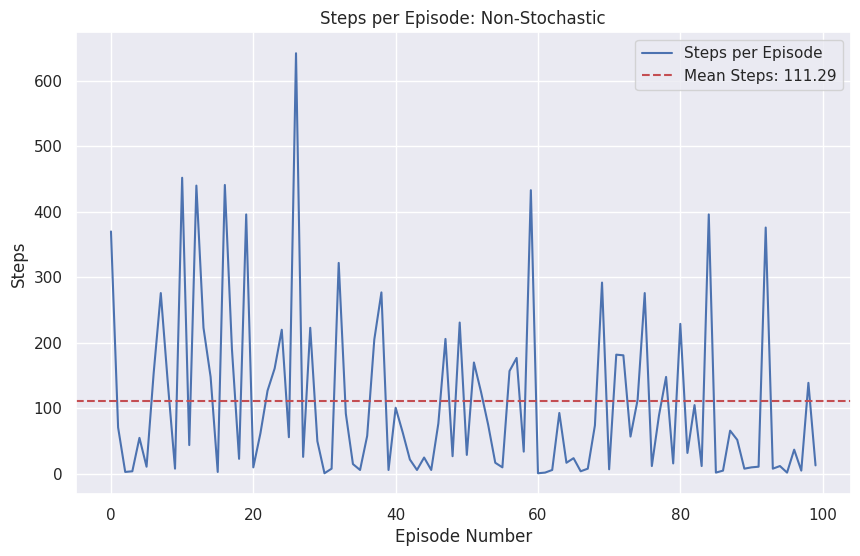

stochastic: 0 - Episodes: 5000
Treinamento em ambiente: non-stochastic


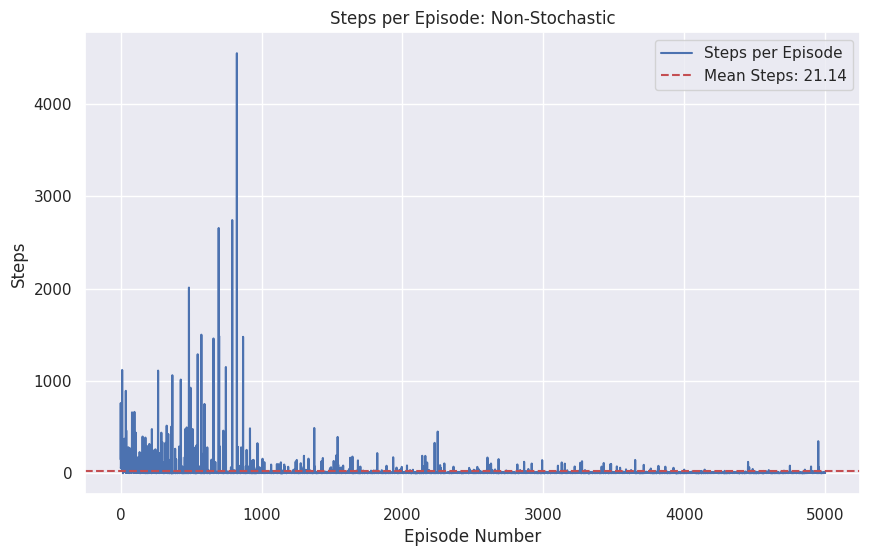

stochastic: 0 - Episodes: 10000
Treinamento em ambiente: non-stochastic


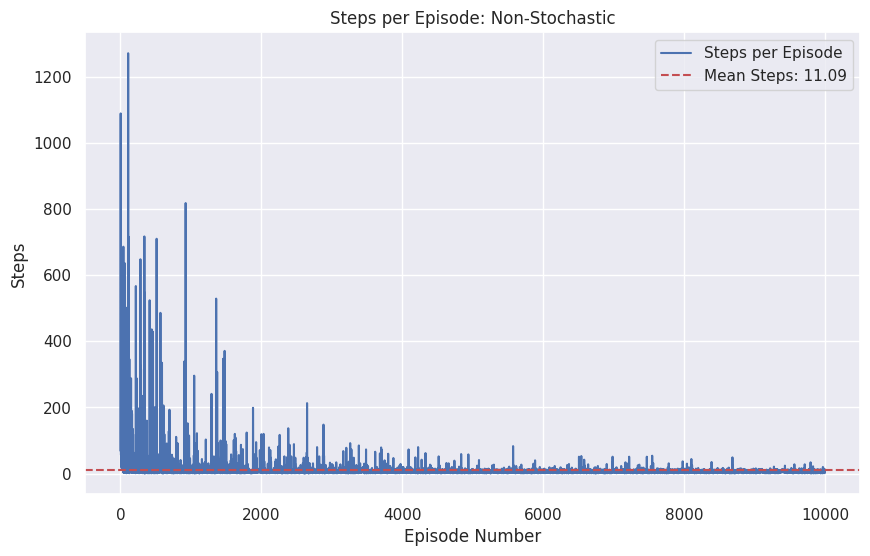

stochastic: 1 - Episodes: 100
Quadrant (0, 0, 2, 2)
Treinamento em ambiente: Partialy


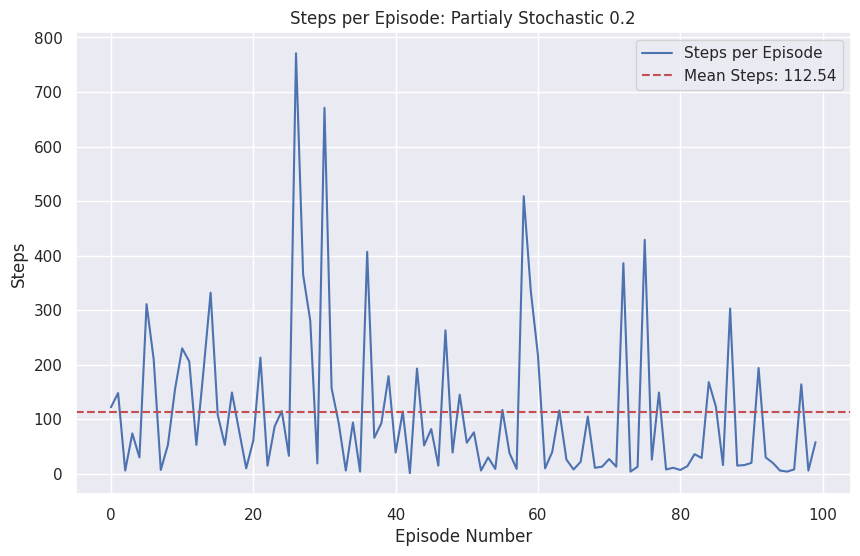

Quadrant (0, 0, 5, 5)
Treinamento em ambiente: Partialy


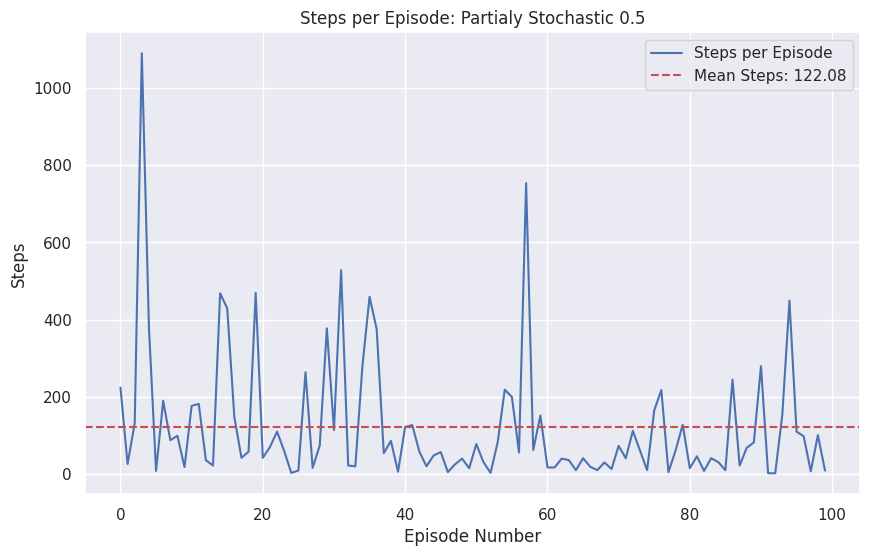

Quadrant (0, 0, 9, 9)
Treinamento em ambiente: Partialy


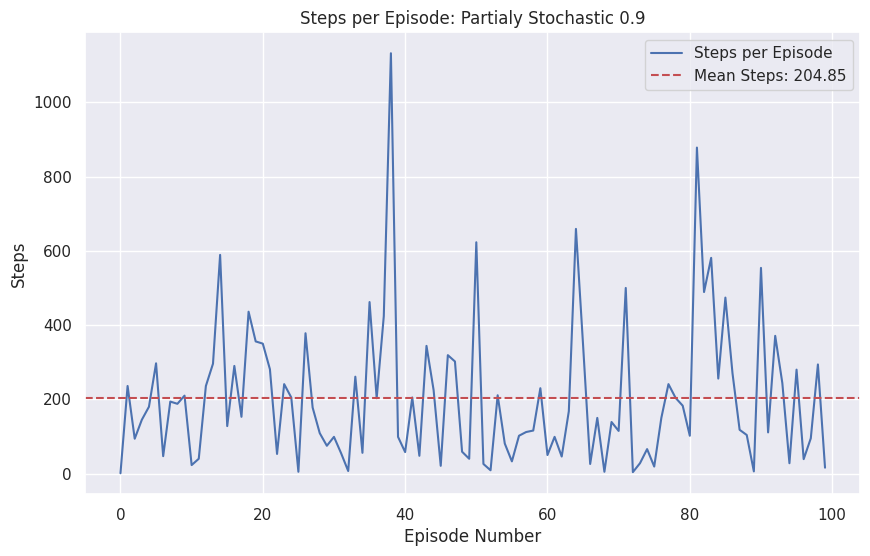

stochastic: 1 - Episodes: 5000
Quadrant (0, 0, 2, 2)
Treinamento em ambiente: Partialy


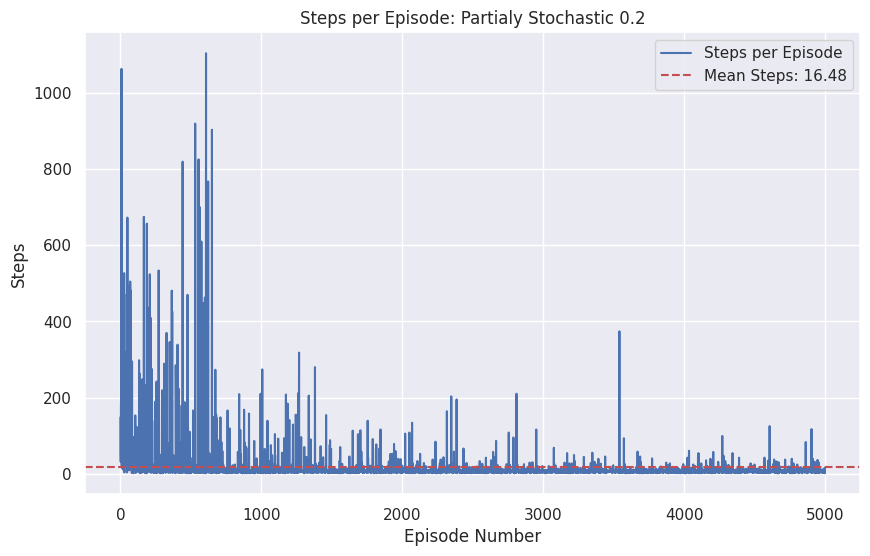

Quadrant (0, 0, 5, 5)
Treinamento em ambiente: Partialy


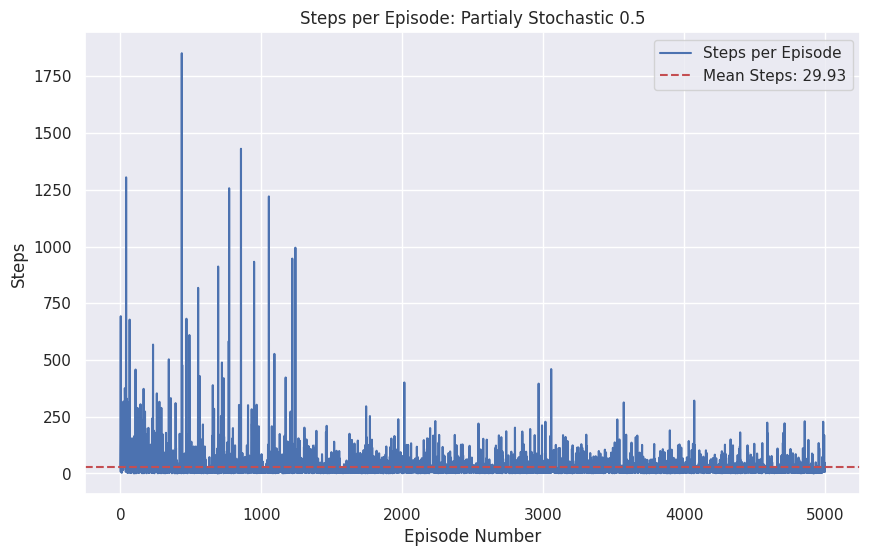

Quadrant (0, 0, 9, 9)
Treinamento em ambiente: Partialy


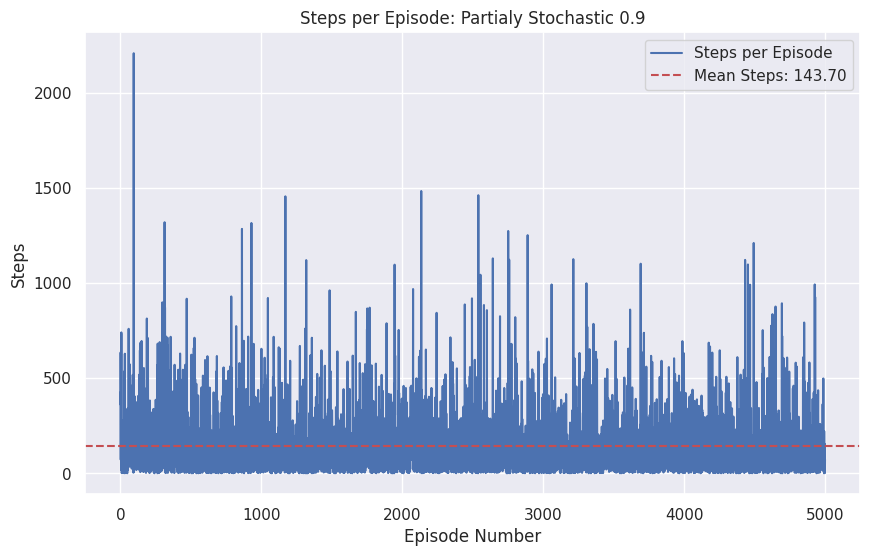

stochastic: 1 - Episodes: 10000
Quadrant (0, 0, 2, 2)
Treinamento em ambiente: Partialy


In [ ]:
test_game = SnakeGame()
episode_size = [100, 5000, 10000]
for stochastic in range(0,2):
  for episodes in episode_size:
    print(f"stochastic: {stochastic} - Episodes: {episodes}")
    if stochastic == 1:
      for percentage in [0.2, 0.5, 0.9]:
        run_q_tests(episodes, stochastic, test_game, percentage)
    else:
      run_q_tests(episodes, stochastic, test_game)

Para testar as politicas:

In [ ]:
# game = SnakeGame()
# game.render()
# agent = MonteCarloAgent(game)

# with open(f'/content/value_function_best_{10000}runs.pkl', 'rb') as fp:
#      value_function = pickle.load(fp)
# agent.value_function = value_function

In [ ]:
# test_method(method = 'random')

In [ ]:
#test_method(method = 'best')

In [ ]:
#test_method(method = 'value')

In [ ]:
# game = SnakeGame()
# game.render()
# agent = MonteCarloAgent(game)

# for i, n in enumerate([[-1, 99], [-10,99], [0, 99]]):
#   with open(f'value_function_reward{i}_100000runs.pkl', 'rb') as fp:
#     value_function = pickle.load(fp)
#     agent.value_function = value_function

#     print(test_method(method = 'value'))

Para testar o N0

In [ ]:
# steps = []
# loop_ratios = []

# for N0 in [1, 10, 100, 1000, 10000]:

#   game = SnakeGame()
#   game.render()
#   agent = MonteCarloAgent(game)

#   agent.run_Monte_Carlo(num_samples = 10000, N0 = N0)

#   step, loop_ratio = test_method(method = 'value')
#   steps.append(step)
#   loop_ratios.append(loop_ratio)

#   print(steps, loop_ratios)

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# sns.lineplot(x = [1, 10, 100, 1000, 10000], y = loop_ratios, ax = axs[0]).set_xscale("log")
# axs[0].set_title('Porcentagem de Loops Variando N0 (log scale)')
# axs[0].set_ylabel('% de Loops')

# sns.lineplot(x = [1, 10, 100, 1000, 10000], y = steps, ax = axs[1]).set_xscale("log")
# axs[1].set_title('Número Médio de passos Variando N0 (log scale)')
# axs[1].set_ylabel('Tamanho médio do episódio')

# axs[0].set_xlabel('Parâmetro N0')
# axs[1].set_xlabel('Parâmetro N0')

### Avaliando o número de iterações de treino

A primeira análise a ser feita, leva em conta o um polica $ϵ$-greedy com N0 = 1000 e uma política de alpha escolhido dinâmicamente, diminuindo proporcionalmente a quantidade de vezes que já se passou pelo local, como se pede na descrição do trabalho.

A função reward foi criada para ser -1 a cada passo do agente e 99 no caso de pegar a fruta/comida, ou seja, chegar no final do episódio.

Os resultados podem ser observados na figura abaixo, que mostra gráficos de calor indicando o valore de cada estado. O eixo x representa a distância do agente até a recompensa (comida ou fruta) no eixo e x, e o mesmo vale para o eixo y do gráfico:

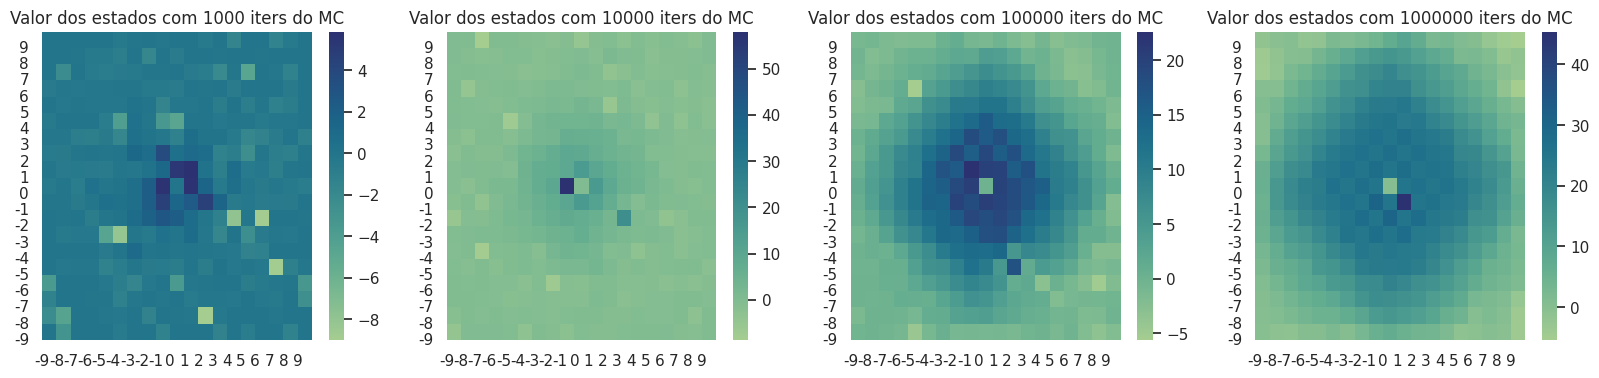

É possível observar que quanto mais o treinamento ocorre, melhor fica a aproximação para um valor ótimo, isto seria, onde os estados mais dintântes possuem valor mínimo e os estados mais centrais possuem valores maiores, considerante que o (0,0) é onde está a fruta, é onde deseja-se chegar.

Uma outra possível comparação a ser feita é saber quantos passos em média cada abordagem levaria para chegar na fruta. Os resultados montraram os seguintes valores (sendo a média de 1000 experimentos aleátórios) e comparados com a política aleatória e com uma regra ótima, criado por nós, que indica o melhor caminho possível sempre:

- Política aleatória: 239 passos em média
- Monte Carlo após 1 Milhão de iterações de treino: 70 passos em média
- Política ótima: 7 passos em média


Segundo nossos análises, o Monte Carlo atingiu o mesmo resultado na maioria dos experimentos, mas fica commédia maior por acabar caindo em loops e subindo a média, uma vez que consideramos a parada após 1000 passos sem chegar na fruta. As taxas de loops (ou episódios maiores que 1000) pode ser visto a seguir:

- Política aleatória: 3,7% de loops
- Monte Carlo após 1 Milhão de iterações de treino: 6,3% de loops
- Política ótima: sem loops


A fim de evitar Loops, fizemos um teste removendo a técnica $ϵ$-greedy na avaliação, e no lugar dela, adicionamos uma probabilidade de 1% de não seguir a política indicada pela função valor, mas sim escolher uma ação aleatória, evitando ficar preso em loops dessa forma.

O resultado foi uma redução para 0.1% de loops apenas e uma redução para 20.3 como tamanho médio do episódio. Mostrando assim que o método de Monte Carlo funcionou e perfoma de maneira bastante eficiente e conseguiu aprender a jogar no ambiente proposto.

### Avaliando o hiperparâmetro N0

A próxima análise a ser realizada se baseia no pararâmetro N0. Podemos ver a seguir um gráfico (em escala logarítimica no eixo x) da quantidade de loops ou episódios com mais de 1000 passos que ocorreram fixando o número de passos de treinamento do Monte Carlo como 10000 e função reward de -1 a cada passo do agente e 99 no caso de pegar a fruta/comida, ou seja, chegar no final do episódio, avaliando assim o efeito da variação do N0 entre 1, 10, 100, 1000, 1000. Já o segundo o gráfico segue a mesma configuranção mas mostra o número médio de passos até se chegar a fruta nas diferentes configurações.




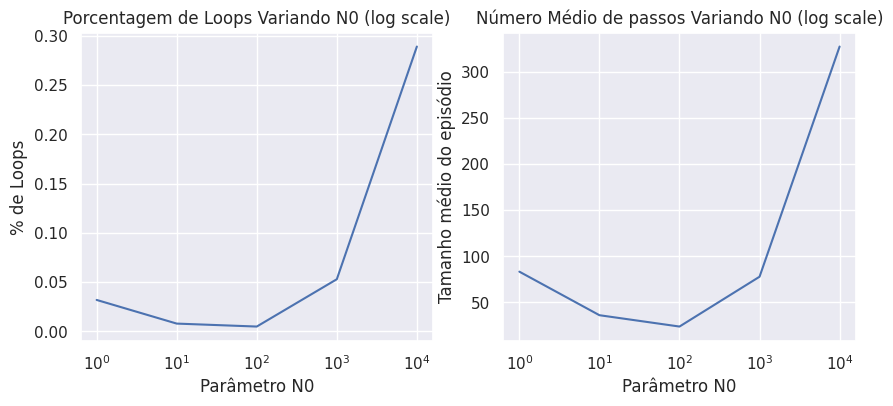

Para o nosso ambiente e nossas configurações coletadas, o que se mostrou mais eficaz foi o N0=100. Isso depende diretamente do problema sendo tratado, uma vez que o tamnho do npumero de estados pode influenciar muito nessa conta.

### Avaliando o ambiente estocástico

Para a avaliar o processo de aprendizado do agente em um ambiente estocático, foram realizados os seguintes exprimentos, fixando o N0=1000 do método ϵ-greedy e alterando o número de iterações de treino:

Para a avaliar a dificuldade no treino, de forma mais ampla, adiciona uma probabilidade de ação escolhida pelo a gente não se concretizar. De forma lúdica, pode ser visto como um "escorregão" ou um vento no agente durante a execução do episódio. Neste primeiro teste, qaulque lugar do tabuleiro pode ocorrer esses eventos aleatórios, abaixo estão mostrados os resultados para a probablidade de ocorrencia de 10%, 50% e 90% desses eventos aleatórios.

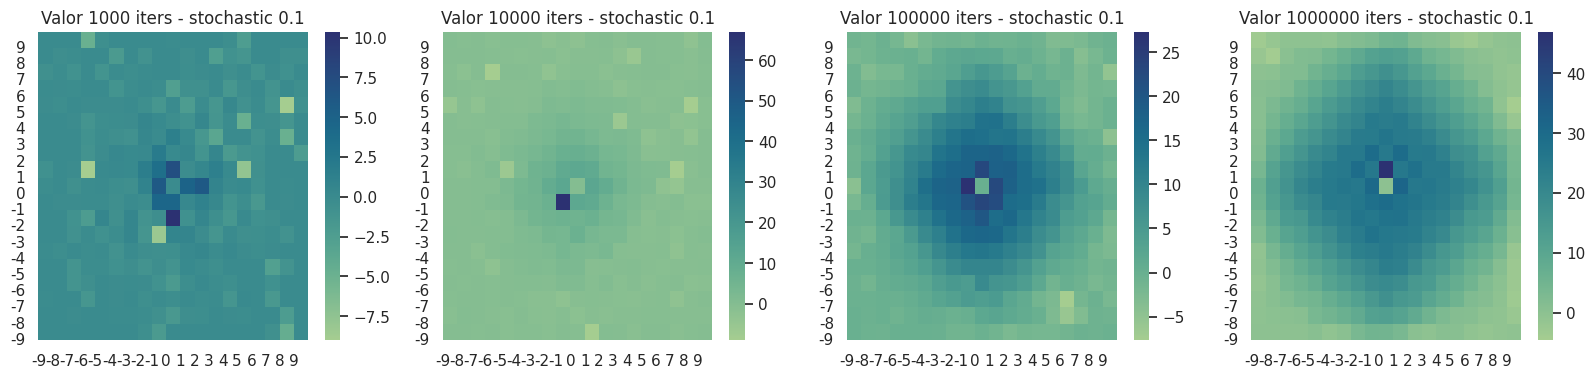

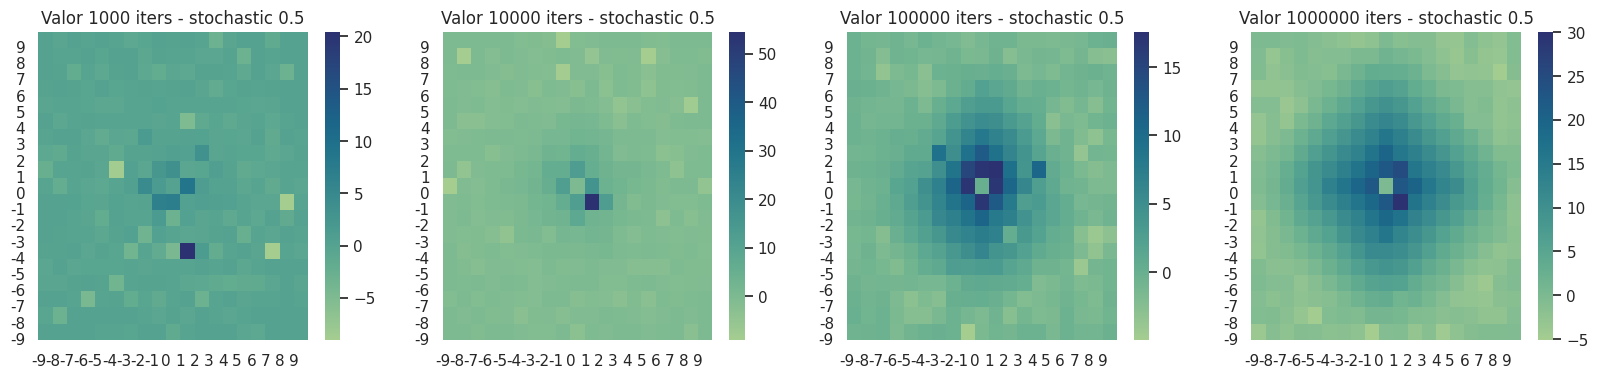

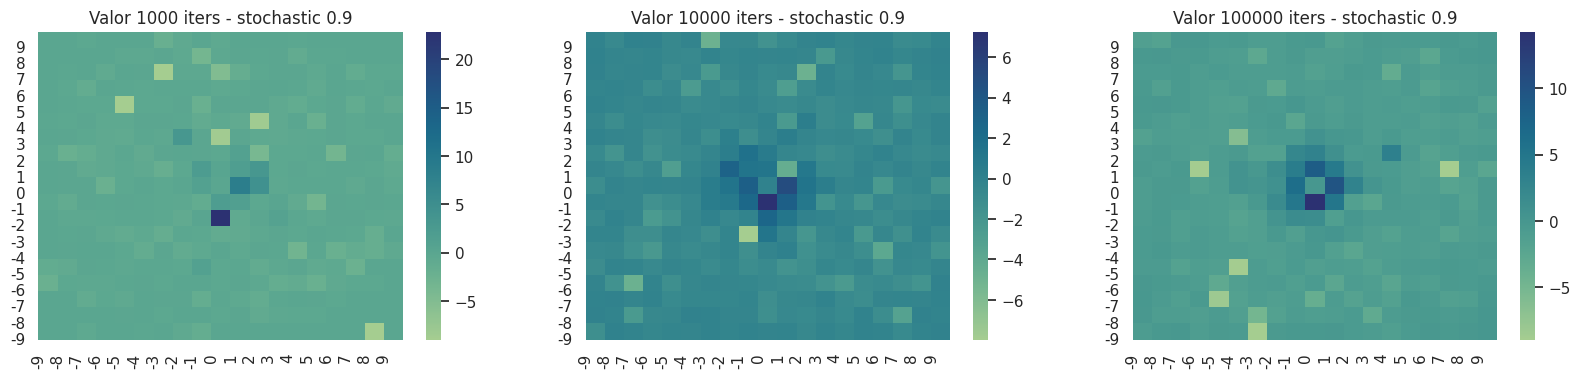

É possível notar, através da análise da uniformidade das cores dos estados representando o valor, nesses casos, a maior dificuldade de aprendizado do agente para ambientes mais estocáticos. Isso se deve por conta da dificuldade de atribuir o valor correto do estado no episódio, demandando mais iterações de treino para efetivamente conseguiur valorá-los.

A diferença nos maios numeros de iterações é evidente, uma vez que no ambiente menos estacástico a função valor ficou mais gradual e menos ruidosa, o agente aprendeu de forma muito mais lenta no caso de um ambiente mais estocástico.

### Avaliando a influencia do reward

Para avaliar a influencia da função reward, mostramos os gráficos abaixo. Nesse caso, usamos o N0=100 para o ϵ-grredy e um alpha dinâmico com requerido e todos foram rodados com 10mil iterações.

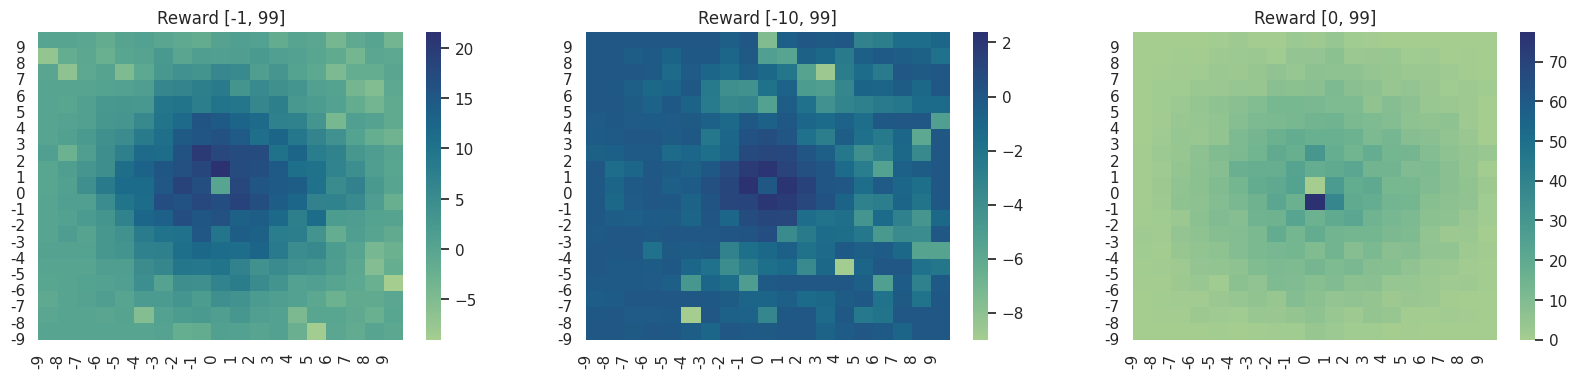

1) O primeiro deles mostra a função utilizada nos testes anteriores, que desconta um ponto a cada passo e adiciona 99 pontos ao conseguir o objetivo. Essa modelagem foi feita para que o agente evite desperdiçar passos, e por isso é punido enquanto anda, e que tente chegar o mais proximo da comida, e por isso é recompensado quando chega. Nesse caso, o tamnho médio do epsódio é 85 e a proporção de loops é de 6,8%

2) O segundo gráfico, mostra um aprendizado mal sucedido, por conta de uma penalização muito alta no andar do agente. Esse desbalanço evidencia a importanâcia do balanço desse reward, uma vez que a recopença no objetivo deve ser suficiente para valorar bem os estados. Nesse caso, o tamnho médio do epsódio é 800 e a proporção de loops é de 79%.

3) O terceiro gráfico mostra o oposto. Nesse caso, não há desconto ao andar, porém há o desconto temporal pelo fator γ da atualização, fazendo com que os estados ainda sejam de certa forma valorados e ainda haja aprendizado. Ou seja, recompensando menos os maiores episódios.  Nesse caso, o tamnho médio do epsódio é 20 e a proporção de loops é de 0,1%


Fica evidente então que um balanço entre a recompensa final e o desconto ao andar, ainda que seja somente pelo fator gamma, torna o aprendizado do agente mais efetivo.

Pórem, encontramos uma modelagem melhor para função reward, que faz com que o a gente aprenda de forma eficiente.

### Avaliando o Melhor que Encontramos

Utilizando todos os testes e informações anteriores, chegamos na melhores características para esse problema:

- O máximo de iterações possíveis, o resutado mostrado é para 100mil.
- N0 sendo 100.
- Função reward apenas com 99 de recompensa no final.


Treinamos um agente com as melhores características, os resultadas de: grafico da função valor, numero médio de passos no epsódio e proporção de loops e episódios maiores que 1000 podem ser vistos abaixo (para rodar, basta descomentar as células abaixo, demora ~1-2min).

- Tamanho médio de 8 à 20 passos por episódio, dependendo da simulação
- Proporção de loops inferior à 0.1%

A seguinte função valor:


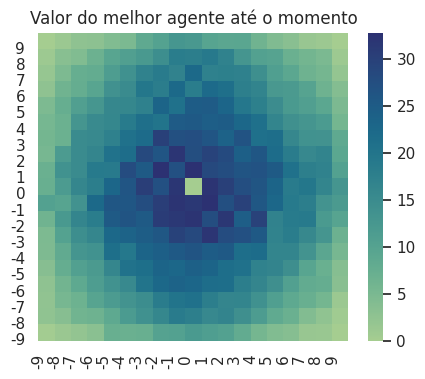

In [ ]:
# game = SnakeGame()
# game.render()
# agent = MonteCarloAgent(game, reward_shape = [0,99])

# agent.run_Monte_Carlo(num_samples = 100000, N0 = 100, stochastic=False)
# value_function = agent.value_function

In [ ]:
# test_method(method = 'value')

In [ ]:
# plt.figure(figsize = (5,4))
# matrix_values = np.zeros((19, 19))
# for k in list(value_function.keys()):
#   x = int(k.split(',')[0].split('(')[1])
#   y = int(k.split(',')[1].split(')')[0])

#   matrix_values[x+9][y+9] = value_function[k]

# matrix_values[9][9] = 0

# a = sns.heatmap(matrix_values, cmap="crest")#, annot = True)
# a.invert_yaxis()
# plt.xticks(range(19))
# a.set_xticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
# plt.yticks(range(19))
# a.set_yticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
# plt.title(f'Valor do melhor agente até o momento')

In [ ]:
game_1 = SnakeGame()
sarsa = Sarsa(game_1)
sarsa.train(1000, sarsa = True)
print(sarsa.q_table)

{((-1, 0), (1, 0)): 134.69129204785963, ((0, -6), (0, -1)): -2.71993615398624, ((0, -7), (0, -1)): -1.900203755757567, ((0, -8), (0, 1)): -2.71087102665486, ((0, -7), (0, 1)): -3.2457539503927153, ((0, -6), (-1, 0)): -2.1584606439738687, ((-1, -6), (0, -1)): -2.6747969208299396, ((-1, -7), (0, -1)): -1.9003832655810549, ((-1, -8), (0, -1)): -1.0000000031537777, ((-1, -9), (0, 1)): -1.9000000552951715, ((-1, -8), (1, 0)): -1.900093039739435, ((0, -7), (-1, 0)): -2.8154475581356055, ((-1, -8), (0, 1)): -2.7114896319840747, ((-1, -7), (1, 0)): -2.729047219897798, ((-1, -7), (0, 1)): -2.5631289217649234, ((-1, -6), (0, 1)): 2.6068641611725107, ((-1, -5), (0, 1)): 15.234222209983894, ((-1, -4), (0, 1)): 37.90183987601862, ((-1, -3), (0, 1)): 63.680482518267695, ((-1, -2), (0, 1)): 7.657763287376528, ((-1, -1), (0, -1)): 3.2173413299444604, ((-1, -2), (0, -1)): -1.0711010605506526, ((-1, -3), (1, 0)): 5.493841828893645, ((0, -3), (0, -1)): -2.249119286812893, ((0, -4), (0, 1)): 18.3069098458

In [ ]:
test_q_policy(agent = sarsa, sarsa = True)

(13.316, 0.001)

In [ ]:
game_1 = SnakeGame()
#agent = RL_Agent(game_1)
agent_sarsa_lambda = Sarsa_lambda(game_1)
#sarsa=True
agent_sarsa_lambda.train_sarsa_lambda(100)

In [ ]:
print(agent_sarsa_lambda.q_table)

{((-9, -9), (1, 0)): -4.322677910291042, ((-9, -9), (-1, 0)): 0.0, ((-9, -9), (0, 1)): -5.16180575801363, ((-9, -9), (0, -1)): 0.0, ((-9, -8), (1, 0)): -5.990590576125181, ((-9, -8), (-1, 0)): 0.0, ((-9, -8), (0, 1)): -9.234224286051653, ((-9, -8), (0, -1)): -4.68849814849436, ((-9, -7), (1, 0)): -9.885533509298616, ((-9, -7), (-1, 0)): 0.0, ((-9, -7), (0, 1)): -7.401135605652957, ((-9, -7), (0, -1)): -7.972198898409608, ((-9, -6), (1, 0)): -7.56239625063482, ((-9, -6), (-1, 0)): 0.0, ((-9, -6), (0, 1)): -7.3329885041352325, ((-9, -6), (0, -1)): -7.434765616111259, ((-9, -5), (1, 0)): -10.414908007245621, ((-9, -5), (-1, 0)): 0.0, ((-9, -5), (0, 1)): -7.8563733139958005, ((-9, -5), (0, -1)): -5.257864118161024, ((-9, -4), (1, 0)): -8.57235415770048, ((-9, -4), (-1, 0)): 0.0, ((-9, -4), (0, 1)): -8.350828320444728, ((-9, -4), (0, -1)): -7.939810023495286, ((-9, -3), (1, 0)): -12.337810287870079, ((-9, -3), (-1, 0)): 0.0, ((-9, -3), (0, 1)): -10.030494330225412, ((-9, -3), (0, -1)): -5.9

In [ ]:
test_q_policy(agent = agent_sarsa_lambda, sarsa = False, sarsa_lambda = True)

(61.45, 0.005)

In [ ]:
sarsa_max_value = {}
dists = [-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9]
actions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
for x in dists:
  for y in dists:
    m = -np.inf
    for a in actions:
      try:
        if sarsa.q_table[((x, y), a)]>m:
          m = sarsa.q_table[((x, y), a)]
          sarsa_max_value[(x, y)] = m
      except KeyError:
        #print(((x, y), a))#sao as bordas
        pass

Text(0.5, 1.0, '--')

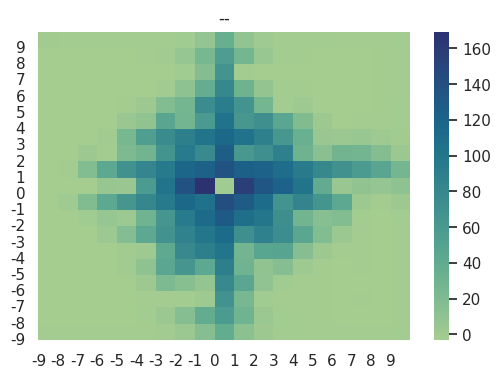

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

value_function = sarsa_max_value

#value_function = agent.value_function
matrix_values = np.zeros((19, 19))
for k in list(value_function.keys()):
  k = str(k)
  x = int(k.split(',')[0].split('(')[1])
  y = int(k.split(',')[1].split(')')[0])

  matrix_values[x+9][y+9] = value_function[(x, y)]

matrix_values[9][9] = 0

sns.heatmap(matrix_values, cmap="crest")#, ax = axs[0])#, annot = True)
axs.invert_yaxis()
axs.set_xticks(range(19))
axs.set_xticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
axs.set_yticks(range(19))
axs.set_yticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
axs.set_title(f'--')

In [ ]:
q_max_value = {}
dists = [-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9]
actions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
for x in dists:
  for y in dists:
    m = -np.inf
    for a in actions:
      try:
        if q_learning.q_table[((x, y), a)]>m:
          m = q_learning.q_table[((x, y), a)]
          q_max_value[(x, y)] = m
      except KeyError:
        #print(((x, y), a))#sao as bordas
        pass

Text(0.5, 1.0, '--')

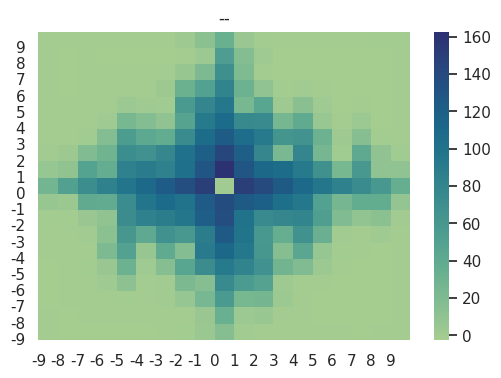

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

value_function = q_max_value

#value_function = agent.value_function
matrix_values = np.zeros((19, 19))
for k in list(value_function.keys()):
  k = str(k)
  x = int(k.split(',')[0].split('(')[1])
  y = int(k.split(',')[1].split(')')[0])

  matrix_values[x+9][y+9] = value_function[(x, y)]

matrix_values[9][9] = 0

sns.heatmap(matrix_values, cmap="crest")#, ax = axs[i], annot = True)
axs.invert_yaxis()
axs.set_xticks(range(19))
axs.set_xticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
axs.set_yticks(range(19))
axs.set_yticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
axs.set_title(f'--')

In [ ]:
sarsa_lambda_max_value = {}
dists = [-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9]
actions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
for x in dists:
  for y in dists:
    m = -np.inf
    for a in actions:
      try:
        if agent_sarsa_lambda.q_table[((x, y), a)]>m:
          m = agent_sarsa_lambda.q_table[((x, y), a)]
          sarsa_lambda_max_value[(x, y)] = m
      except KeyError:
        #print(((x, y), a))#sao as bordas
        pass

Text(0.5, 1.0, '--')

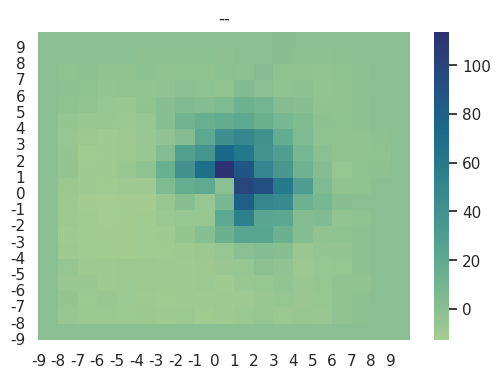

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

value_function = sarsa_lambda_max_value

#value_function = agent.value_function
matrix_values = np.zeros((19, 19))
for k in list(value_function.keys()):
  k = str(k)
  x = int(k.split(',')[0].split('(')[1])
  y = int(k.split(',')[1].split(')')[0])

  matrix_values[x+9][y+9] = value_function[(x, y)]

matrix_values[9][9] = 0

sns.heatmap(matrix_values, cmap="crest")#, ax = axs[i], annot = True)
axs.invert_yaxis()
axs.set_xticks(range(19))
axs.set_xticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
axs.set_yticks(range(19))
axs.set_yticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
axs.set_title(f'--')

In [ ]:
class MonteCarloAgent():
    def __init__(self, game, gamma = 0.9, reward_shape = [-1, 99]):
        self.game = game
        self.V = {}
        self.gamma = gamma
        self.reward_shape = reward_shape
        self.value_function = self.create_value_function()
        self.states_count = self.create_states_count()
        self.states_and_actions = self.create_states_and_actions()

        self.weights = np.zeros(3) #2 features and 1 bias
        self.loss = []

    def get_state(self):
      s = self.game.snake[0]
      f = self.game.food

      state_x = s[0] - f[0]
      state_y = s[1] - f[1]

      return (state_x, state_y)


    def state_to_str(self, state):
        return str(state)

    def create_value_function(self):
      global GRID_HEIGHT
      global GRID_WIDTH
      value = {}

      for x in range(-GRID_WIDTH+1, GRID_WIDTH):
        for y in range(-GRID_HEIGHT+1, GRID_HEIGHT):

          value[f'({x}, {y})'] = 0

      value[str((0,0))] = np.inf #pois esse é estado final e o que mais vale
      return value

    def create_states_count(self):
      global GRID_HEIGHT
      global GRID_WIDTH
      N = {}

      for x in range(-GRID_WIDTH+1, GRID_WIDTH):
        for y in range(-GRID_HEIGHT+1, GRID_HEIGHT):

          N[f'({x}, {y})'] = 0

      return N


    def create_states_and_actions(self):
      global GRID_HEIGHT
      global GRID_WIDTH
      N = {}

      for x in range(-GRID_WIDTH+1, GRID_WIDTH):
        for y in range(-GRID_HEIGHT+1, GRID_HEIGHT):

          N[f'({x}, {y})'] = {(1,0):0, (-1,0):0, (0,1):0, (0,-1):0 }
      return N

    def run_episode(self, method = 'random', alpha= 0.1, gamma = 0.9, test_only = False, render = False, N0 = 1, N = 1,
                    stochastic = False):

        episode_states = []
        episode_rewards = 0

        self.game.reset()
        get = False
        while not get:
            state = self.get_state()
            state_str = self.state_to_str(state)
            episode_states.append(state)

            self.states_count[state_str] = self.states_count[state_str]+1
            N = self.states_count[str(episode_states[0])]

            reward, done, get, action = self.game.step(self.reward_shape, method = method, N0 = N0, N = N,
                                                       value_function = self.value_function, test_only = test_only,
                                                       stochastic = stochastic, weights = self.weights
                                                       )

            if len(episode_states) == 1:
              first_action = action

            self.game.render(render = render)
            episode_rewards += gamma**(len(episode_states)) * reward

            self.states_and_actions[state_str][action] = self.states_and_actions[state_str][action]+1


            if len(episode_states)>1000:
              #print('Loop =( Energia acabou...')
              break
            if not done:
                break

        if not test_only:

          v = self.value_function[str(episode_states[0])]
          alpha = 1/self.states_and_actions[str(episode_states[0])][first_action]
          self.value_function[str(episode_states[0])] = v + alpha*(episode_rewards - v)

          #to train the linear aproximator function
          self.MC_linear_aproximator(state = episode_states[0],
                                     V_sampled = self.value_function[str(episode_states[0])])

        ep_len = len(episode_states)

        return ep_len

    def run_Monte_Carlo(self, num_samples = 1, alpha = 0.1, N0 = 0, N = 1, stochastic = False):

      for i in range(num_samples):
        self.run_episode(alpha = alpha, method = 'value', N0 = N0, N = N, stochastic = stochastic)


    def MC_linear_aproximator(self, state, V_sampled, epochs = 1, lr = 0.00001, n=1):

      #V_sampled = 2*state[0] + 5*state[1] + 10

      features = [0,0]
      features[0] = abs(state[0])
      features[1] = abs(state[1])

      for i in range(epochs):

        V_pred = self.weights[0]*features[0] + self.weights[1]*features[1] +  self.weights[2] #Linear equation: Y = a_1*x_1 + a_2*x_2 + b
        #print(state, V_sampled, V_pred)

        D0 = (features[0] * (V_pred - V_sampled)) #gradient
        self.weights[0] = self.weights[0] - (lr * D0) #update

        D1 = (features[1] * (V_pred - V_sampled)) #gradient
        self.weights[1] = self.weights[1] - (lr * D1) #update

        D2 = (V_pred - V_sampled) #gradient
        self.weights[2] = self.weights[2] - (lr * D2) #update

      loss = 0.5 * (V_pred - V_sampled)**2

      #print(self.weights)
      self.loss.append(loss)



# Testes do Método de Monte Carlo

## Códigos e Funções

Abaixo estão listados os códigos que usamos para rodar esses experimentos. Isso pode demorar um pouco e por isso estão comentados. Os resultados serão exibidos na próxima seção.

In [ ]:
#essa função é para medir diferentes abordagens,
#com ela podemos ver quantos passos em média cada politca demora para chegar no objetivo
#além disso, podemos ver a % de vezes que o jogo entra em loop, ou seja, masi de 1000 passos

def test_method(method, n_iter = 1000):
  ep_len_total = 0
  loop = 0
  for i in range(n_iter):

    ep_len = agent.run_episode(method = method, render = False, test_only = True)
    ep_len_total +=  ep_len

    if ep_len>=999:
      loop+=1

  ep_len_mean = ep_len_total/n_iter
  prop_loop = loop/n_iter

  return ep_len_mean, prop_loop

In [ ]:
#criando o jogo e o agente monte carlo
game = SnakeGame()
game.render()
agent = MonteCarloAgent(game)

In [ ]:
#fazendo um teste com a politica aleatoria
for i in range(10):
  agent.run_episode(method = 'random', render = False)

In [ ]:
agent.weights

array([ 0.00063323, -0.00097631,  0.00056622])

In [ ]:
test_method(method = 'linear_aproximator')

(887.813, 0.873)

In [ ]:
test_method(method = 'random')

(228.371, 0.021)

In [ ]:
# O código abaixo roda diferentes numeros de treinamentos
# Ele é responsável por tetsar o efeito da quantidade de treino
# Foi fixado um N0=1000 e um aplha dinâmico, como requisitado

# for i, r in enumerate([[0, 99]]):#[1000, 10000, 100000, 1000000]:
#   game = SnakeGame()
#   game.render()
#   agent = MonteCarloAgent(game, reward_shape = r)

#   agent.run_Monte_Carlo(num_samples = 100000, N0 = 100, stochastic=False)

#   with open(f'value_function_best_100000runs.pkl', 'wb') as fp:
#     pickle.dump(agent.value_function, fp)

In [ ]:
#A proxima célula le a função valor salva dos treinamentos anteriores e plota ela
# Assim, podemos avaliar como se comportam

# fig, axs = plt.subplots(1, 3, figsize=(20, 4))
# for i, n in enumerate([[-1, 99], [-10,99], [0, 99]]):
#   with open(f'value_function_reward{i}_100000runs.pkl', 'rb') as fp:
#     value_function = pickle.load(fp)

#   #value_function = agent.value_function
#   matrix_values = np.zeros((19, 19))
#   for k in list(value_function.keys()):
#     x = int(k.split(',')[0].split('(')[1])
#     y = int(k.split(',')[1].split(')')[0])

#     matrix_values[x+9][y+9] = value_function[k]

#   matrix_values[9][9] = 0

#   sns.heatmap(matrix_values, ax = axs[i], cmap="crest")#, annot = True)
#   axs[i].invert_yaxis()
#   axs[i].set_xticks(range(19))
#   axs[i].set_xticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
#   axs[i].set_yticks(range(19))
#   axs[i].set_yticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
#   axs[i].set_title(f'Reward {n}')

Para testar as politicas:

In [ ]:
# game = SnakeGame()
# game.render()
# agent = MonteCarloAgent(game)

# with open(f'/content/value_function_best_{10000}runs.pkl', 'rb') as fp:
#      value_function = pickle.load(fp)
# agent.value_function = value_function

In [ ]:
# test_method(method = 'random')

In [ ]:
#test_method(method = 'best')

In [ ]:
#test_method(method = 'value')

In [ ]:
# game = SnakeGame()
# game.render()
# agent = MonteCarloAgent(game)

# for i, n in enumerate([[-1, 99], [-10,99], [0, 99]]):
#   with open(f'value_function_reward{i}_100000runs.pkl', 'rb') as fp:
#     value_function = pickle.load(fp)
#     agent.value_function = value_function

#     print(test_method(method = 'value'))

Para testar o N0

In [ ]:
# steps = []
# loop_ratios = []

# for N0 in [1, 10, 100, 1000, 10000]:

#   game = SnakeGame()
#   game.render()
#   agent = MonteCarloAgent(game)

#   agent.run_Monte_Carlo(num_samples = 10000, N0 = N0)

#   step, loop_ratio = test_method(method = 'value')
#   steps.append(step)
#   loop_ratios.append(loop_ratio)

#   print(steps, loop_ratios)

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# sns.lineplot(x = [1, 10, 100, 1000, 10000], y = loop_ratios, ax = axs[0]).set_xscale("log")
# axs[0].set_title('Porcentagem de Loops Variando N0 (log scale)')
# axs[0].set_ylabel('% de Loops')

# sns.lineplot(x = [1, 10, 100, 1000, 10000], y = steps, ax = axs[1]).set_xscale("log")
# axs[1].set_title('Número Médio de passos Variando N0 (log scale)')
# axs[1].set_ylabel('Tamanho médio do episódio')

# axs[0].set_xlabel('Parâmetro N0')
# axs[1].set_xlabel('Parâmetro N0')

## Análises Monte Carlo

### Avaliando o número de iterações de treino

A primeira análise a ser feita, leva em conta o um polica $ϵ$-greedy com N0 = 1000 e uma política de alpha escolhido dinâmicamente, diminuindo proporcionalmente a quantidade de vezes que já se passou pelo local, como se pede na descrição do trabalho.

A função reward foi criada para ser -1 a cada passo do agente e 99 no caso de pegar a fruta/comida, ou seja, chegar no final do episódio.

Os resultados podem ser observados na figura abaixo, que mostra gráficos de calor indicando o valore de cada estado. O eixo x representa a distância do agente até a recompensa (comida ou fruta) no eixo e x, e o mesmo vale para o eixo y do gráfico:

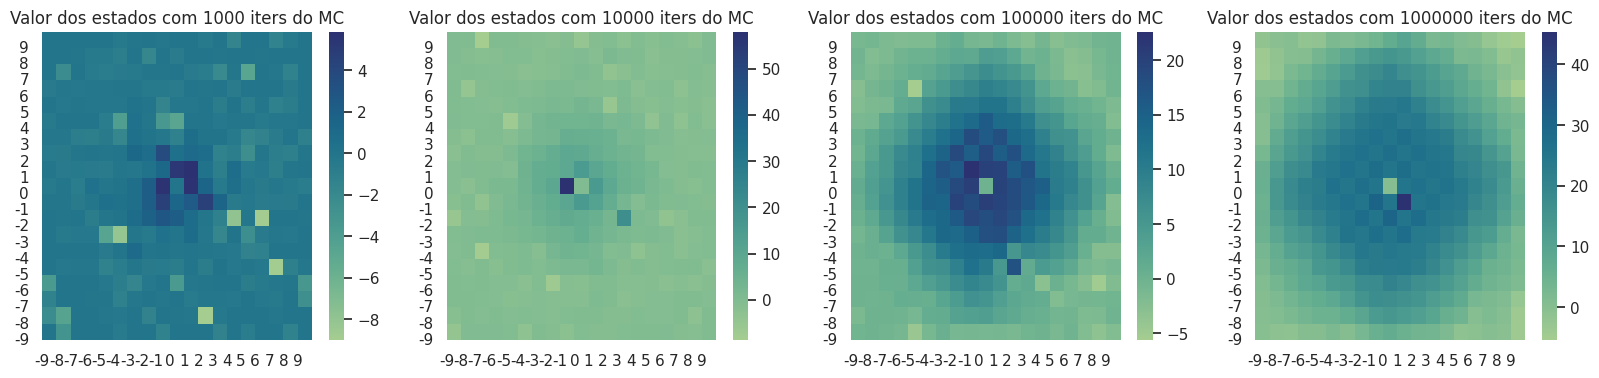

É possível observar que quanto mais o treinamento ocorre, melhor fica a aproximação para um valor ótimo, isto seria, onde os estados mais dintântes possuem valor mínimo e os estados mais centrais possuem valores maiores, considerante que o (0,0) é onde está a fruta, é onde deseja-se chegar.

Uma outra possível comparação a ser feita é saber quantos passos em média cada abordagem levaria para chegar na fruta. Os resultados montraram os seguintes valores (sendo a média de 1000 experimentos aleátórios) e comparados com a política aleatória e com uma regra ótima, criado por nós, que indica o melhor caminho possível sempre:

- Política aleatória: 239 passos em média
- Monte Carlo após 1 Milhão de iterações de treino: 70 passos em média
- Política ótima: 7 passos em média


Segundo nossos análises, o Monte Carlo atingiu o mesmo resultado na maioria dos experimentos, mas fica commédia maior por acabar caindo em loops e subindo a média, uma vez que consideramos a parada após 1000 passos sem chegar na fruta. As taxas de loops (ou episódios maiores que 1000) pode ser visto a seguir:

- Política aleatória: 3,7% de loops
- Monte Carlo após 1 Milhão de iterações de treino: 6,3% de loops
- Política ótima: sem loops


A fim de evitar Loops, fizemos um teste removendo a técnica $ϵ$-greedy na avaliação, e no lugar dela, adicionamos uma probabilidade de 1% de não seguir a política indicada pela função valor, mas sim escolher uma ação aleatória, evitando ficar preso em loops dessa forma.

O resultado foi uma redução para 0.1% de loops apenas e uma redução para 20.3 como tamanho médio do episódio. Mostrando assim que o método de Monte Carlo funcionou e perfoma de maneira bastante eficiente e conseguiu aprender a jogar no ambiente proposto.

### Avaliando o hiperparâmetro N0

A próxima análise a ser realizada se baseia no pararâmetro N0. Podemos ver a seguir um gráfico (em escala logarítimica no eixo x) da quantidade de loops ou episódios com mais de 1000 passos que ocorreram fixando o número de passos de treinamento do Monte Carlo como 10000 e função reward de -1 a cada passo do agente e 99 no caso de pegar a fruta/comida, ou seja, chegar no final do episódio, avaliando assim o efeito da variação do N0 entre 1, 10, 100, 1000, 1000. Já o segundo o gráfico segue a mesma configuranção mas mostra o número médio de passos até se chegar a fruta nas diferentes configurações.




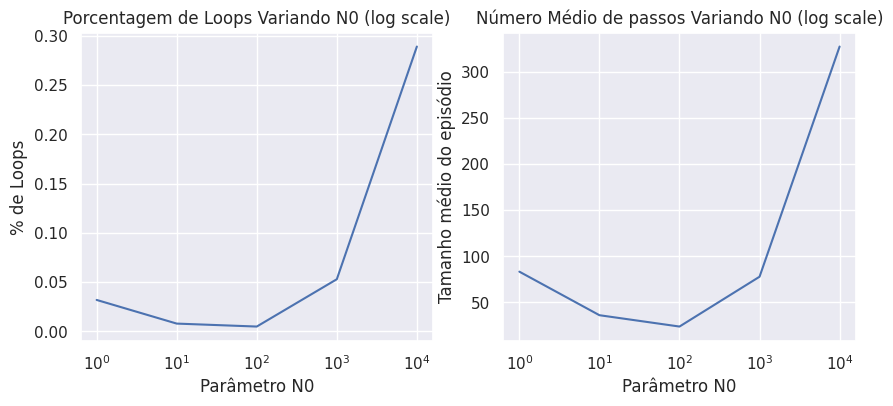

Para o nosso ambiente e nossas configurações coletadas, o que se mostrou mais eficaz foi o N0=100. Isso depende diretamente do problema sendo tratado, uma vez que o tamnho do npumero de estados pode influenciar muito nessa conta.

### Avaliando o ambiente estocástico

Para a avaliar o processo de aprendizado do agente em um ambiente estocático, foram realizados os seguintes exprimentos, fixando o N0=1000 do método ϵ-greedy e alterando o número de iterações de treino:

Para a avaliar a dificuldade no treino, de forma mais ampla, adiciona uma probabilidade de ação escolhida pelo a gente não se concretizar. De forma lúdica, pode ser visto como um "escorregão" ou um vento no agente durante a execução do episódio. Neste primeiro teste, qaulque lugar do tabuleiro pode ocorrer esses eventos aleatórios, abaixo estão mostrados os resultados para a probablidade de ocorrencia de 10%, 50% e 90% desses eventos aleatórios.

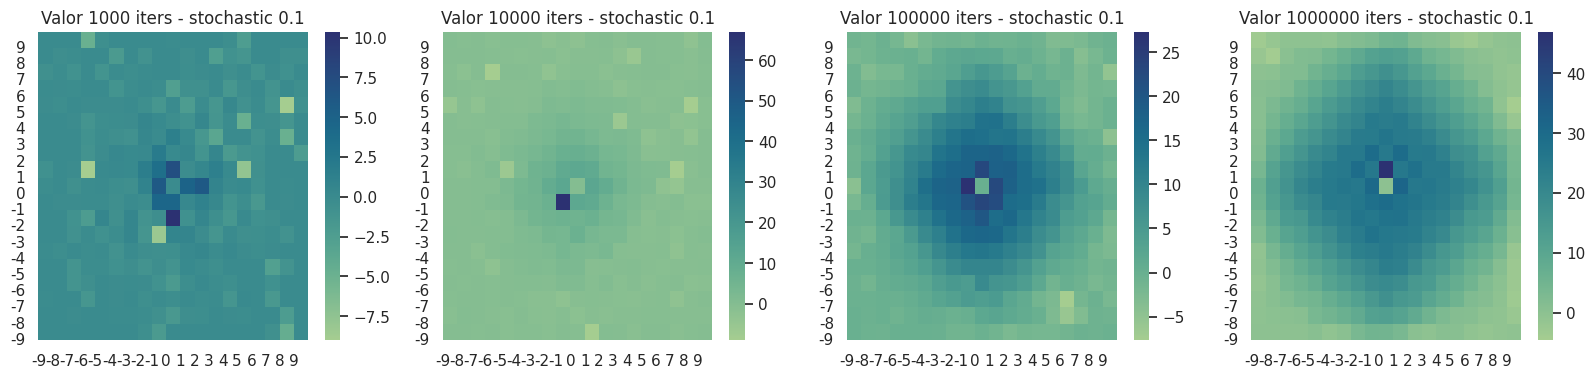

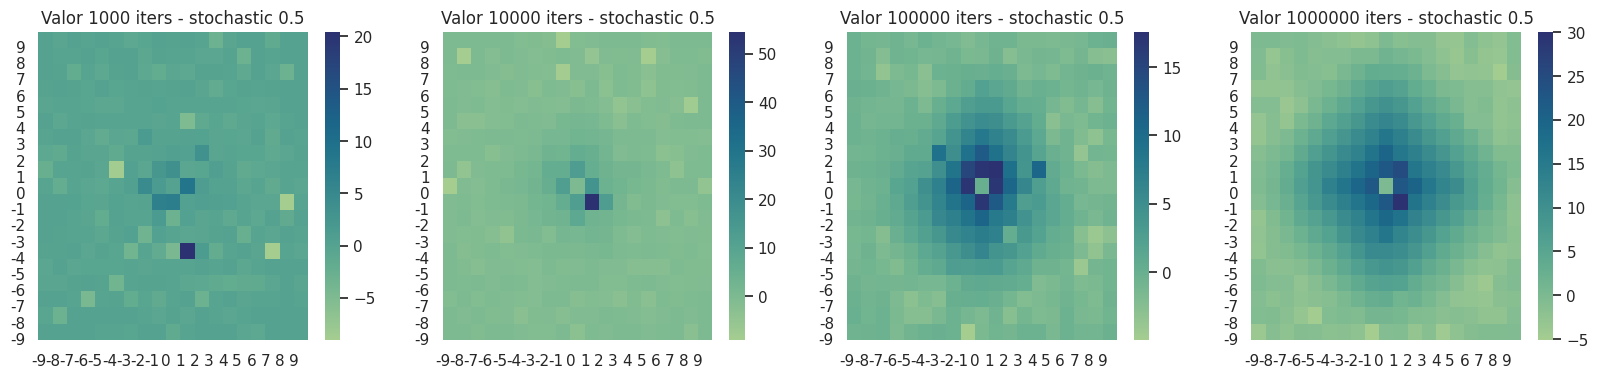

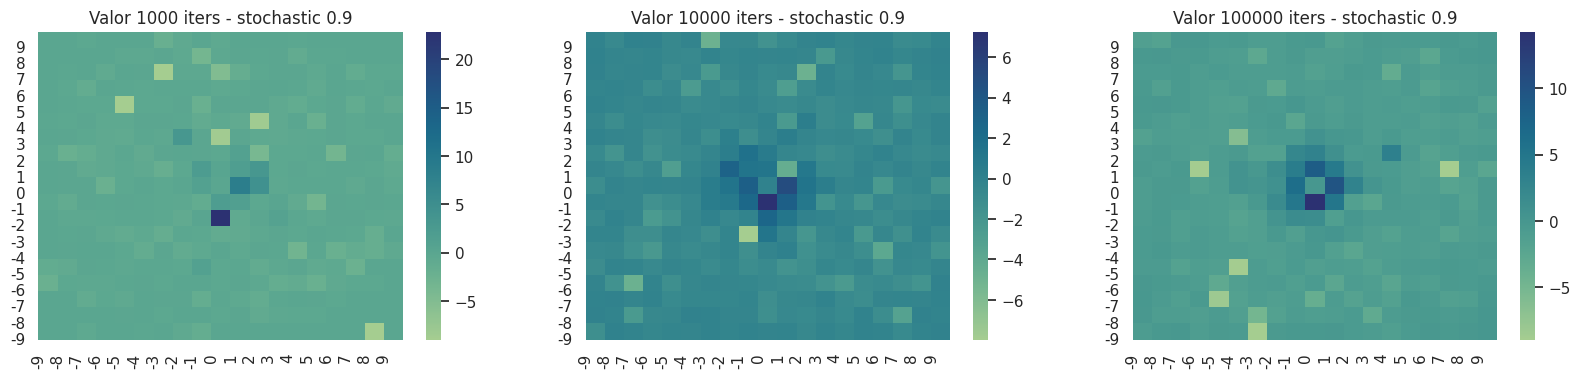

É possível notar, através da análise da uniformidade das cores dos estados representando o valor, nesses casos, a maior dificuldade de aprendizado do agente para ambientes mais estocáticos. Isso se deve por conta da dificuldade de atribuir o valor correto do estado no episódio, demandando mais iterações de treino para efetivamente conseguiur valorá-los.

A diferença nos maios numeros de iterações é evidente, uma vez que no ambiente menos estacástico a função valor ficou mais gradual e menos ruidosa, o agente aprendeu de forma muito mais lenta no caso de um ambiente mais estocástico.

### Avaliando a influencia do reward

Para avaliar a influencia da função reward, mostramos os gráficos abaixo. Nesse caso, usamos o N0=100 para o ϵ-grredy e um alpha dinâmico com requerido e todos foram rodados com 10mil iterações.

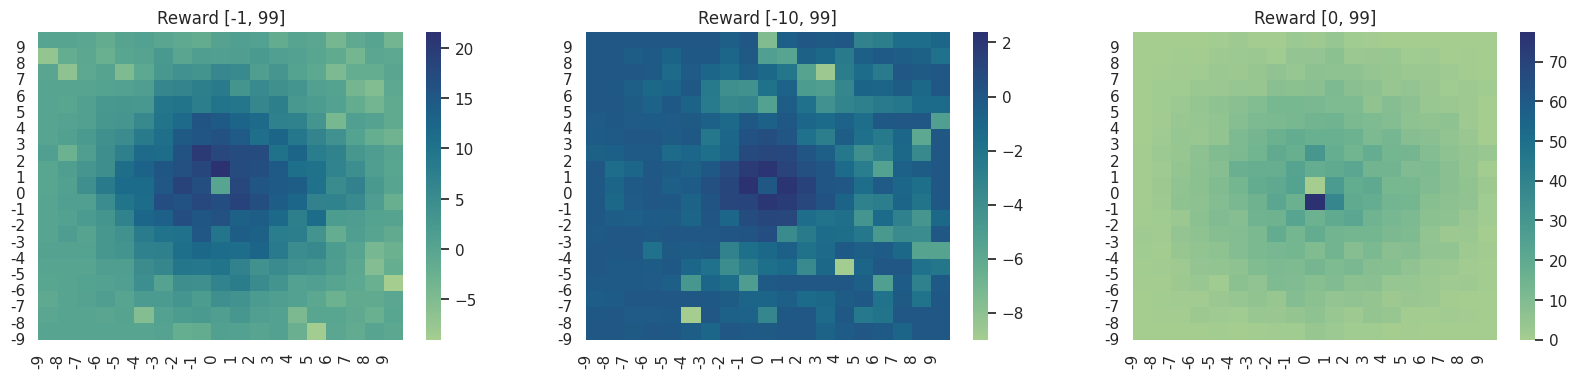

1) O primeiro deles mostra a função utilizada nos testes anteriores, que desconta um ponto a cada passo e adiciona 99 pontos ao conseguir o objetivo. Essa modelagem foi feita para que o agente evite desperdiçar passos, e por isso é punido enquanto anda, e que tente chegar o mais proximo da comida, e por isso é recompensado quando chega. Nesse caso, o tamnho médio do epsódio é 85 e a proporção de loops é de 6,8%

2) O segundo gráfico, mostra um aprendizado mal sucedido, por conta de uma penalização muito alta no andar do agente. Esse desbalanço evidencia a importanâcia do balanço desse reward, uma vez que a recopença no objetivo deve ser suficiente para valorar bem os estados. Nesse caso, o tamnho médio do epsódio é 800 e a proporção de loops é de 79%.

3) O terceiro gráfico mostra o oposto. Nesse caso, não há desconto ao andar, porém há o desconto temporal pelo fator γ da atualização, fazendo com que os estados ainda sejam de certa forma valorados e ainda haja aprendizado. Ou seja, recompensando menos os maiores episódios.  Nesse caso, o tamnho médio do epsódio é 20 e a proporção de loops é de 0,1%


Fica evidente então que um balanço entre a recompensa final e o desconto ao andar, ainda que seja somente pelo fator gamma, torna o aprendizado do agente mais efetivo.

Pórem, encontramos uma modelagem melhor para função reward, que faz com que o a gente aprenda de forma eficiente.

### Avaliando o Melhor que Encontramos

Utilizando todos os testes e informações anteriores, chegamos na melhores características para esse problema:

- O máximo de iterações possíveis, o resutado mostrado é para 100mil.
- N0 sendo 100.
- Função reward apenas com 99 de recompensa no final.


Treinamos um agente com as melhores características, os resultadas de: grafico da função valor, numero médio de passos no epsódio e proporção de loops e episódios maiores que 1000 podem ser vistos abaixo (para rodar, basta descomentar as células abaixo, demora ~1-2min).

- Tamanho médio de 8 à 20 passos por episódio, dependendo da simulação
- Proporção de loops inferior à 0.1%

A seguinte função valor:


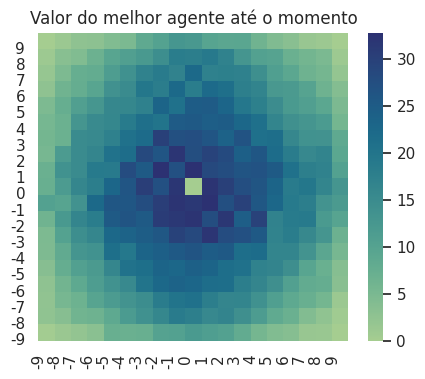

In [ ]:
# game = SnakeGame()
# game.render()
# agent = MonteCarloAgent(game, reward_shape = [0,99])

# agent.run_Monte_Carlo(num_samples = 100000, N0 = 100, stochastic=False)
# value_function = agent.value_function

In [ ]:
# test_method(method = 'value')

In [ ]:
# plt.figure(figsize = (5,4))
# matrix_values = np.zeros((19, 19))
# for k in list(value_function.keys()):
#   x = int(k.split(',')[0].split('(')[1])
#   y = int(k.split(',')[1].split(')')[0])

#   matrix_values[x+9][y+9] = value_function[k]

# matrix_values[9][9] = 0

# a = sns.heatmap(matrix_values, cmap="crest")#, annot = True)
# a.invert_yaxis()
# plt.xticks(range(19))
# a.set_xticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
# plt.yticks(range(19))
# a.set_yticklabels([-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9])
# plt.title(f'Valor do melhor agente até o momento')

## Analises Aproximador Linear

A fim de analisar a última forma requerida de Reiforcement Learning, criamos um aproximador linear de função, que tem seus pesos otimizados no treinamento através do gradiente descendente, a cada episodio realizado. Os resultados foram interessantes e mostram o poder desse tipo de aproximação na solução do problema.

Sendo um problema bastante simples tratado aqui, o aproximador linear função de maneira satrisfatória, porém em ambientes mais complexos talvez fosse nessário função mais complexas e o uso de redes neurais profundas para calcular a aproximação do valor dos estados.

### Monte Carlo

Os primeiros testes foram realizados no monte carlo e geraram resultados surpreendentes. No nosso cenário consideramos 3 pesos: Um para distância no eixo x, um para distância em y e um de bias da regressão linear.

Como recomendado em aula, também criamos features dos nossos estados, o que auxiliou bastante na convergência do modelo linear, que não alcança resultados satisfatórios sem tais features. Essas features são simplesmente o módulo (valor absoluto) de cada entrada do estado e foi tão efetiva pois acaba representando melhor a distância até o objetivo.

Como resultado, apenas 10 epsódios rodados já sufiente para gerar uma boa aproximação dos pesos para estimação do valor dos estados. Porém entendemos que isso se deve a baixa complexidade do cenário, além do fato de ele já ser discretizado, que torna a função muito fácil de ser ajustada.

Como resultado, obtemos uma média de passos por epsódio de ~7.8, e nenhuma loop acanteceu durante os testes, que é resultado muito bom pelo que vinhamos testando anteriormente. E pode ser visto no código a seguir.

O learning rate utilizado é de 0.00001 e o reward é de -1 por passo e 99 no objetivo.

In [ ]:
#criando o jogo e o agente monte carlo
game = SnakeGame()
game.render()
agent = MonteCarloAgent(game)

for i in range(10): #rodando epsódios para teinar os pesos da regressao linear
  agent.run_episode(method = 'random', render = False)

test_method(method = 'linear_aproximator', n_iter = 10000) #testando com o valor estimado pela regressao

(7.7275, 0.0)